# Glauber dynamics on asymmetric directed graphs

In [ ]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, SparseArrays
using Random, Statistics
using Plots, LaTeXStrings
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value
using JLD2;

In [ ]:
T = 20
N = 50
k = 4
seed = 0
rng = MersenneTwister(seed)
gg = random_regular_graph(N, k; seed)
# gg = prufer_decode(rand(rng, 1:N, N-2))
# gg = path_graph(N)
A = adjacency_matrix(gg)
rand!(rng, A.nzval, (-1,1))  # fill directed incidence matrix with rand(-1,1)
g = IndexedBiDiGraph(gg)
β = 1.0
J = 1.0
h = 0.5
w = [fill(PMJGlauberFactor([A[j,i] for j in inneighbors(g,i)], J, h, β), T+1) for i in vertices(g)]
# w = [fill(GenericGlauberFactor([A[j,i] for j in inneighbors(g,i)]*J, h, β), T+1) for i in vertices(g)]
m⁰ = -0.5
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp(g, w, fill(2,N), T; ϕ=fill(ϕᵢ,N));

In [ ]:
using GraphRecipes
graphplot(SimpleDiGraph(A), curves=false, size=(800,800), nodeshape=:circle,
    nodecolor=:black, nodesize=0.01, arrow=arrow(:closed, 0.1))

In [ ]:
reset!(bp)
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
cb = CB_BP(bp; f=spin);

In [ ]:
svd_trunc = TruncBondThresh(12, 1e-6)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2);

In [ ]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [17]:
m_bp = means(spin, bp);

In [ ]:
sms = SoftMarginSampler(bp);

In [ ]:
sample!(sms, 5*10^4);

In [19]:
b_mc = marginals(sms)
m_mc = means(spin, sms);

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:01
Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:00


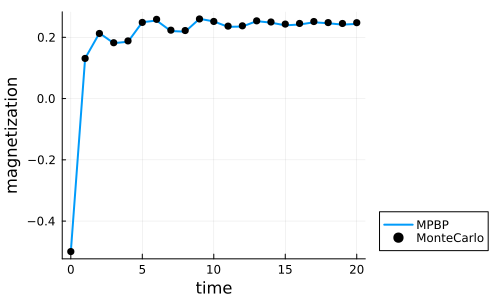

In [24]:
pl = plot(0:T, mean(m_bp), lw=2, xlabel="time", ylabel="magnetization",
    size=(500,300), label="MPBP", legend=:outerbottomright)
scatter!(pl, 0:T, value.(mean(m_mc)), c=:black,label="MonteCarlo")
# plot!(pl, 0:T, mean(m_exact), ls=:dash, c=:red, label="Exact")

In [25]:
c_bp = autocovariances(spin, bp)
c_mc_ = autocovariances(spin, sms)
c_mc = [[value(x) for x in xx] for xx in c_mc_];

Autocorrelations from Soft Margin 100%|██████████████████| Time: 0:04:27
Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:01


In [28]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, ΔT=1.0, 
        us=0:(2*floor(Int, T/10)):T, cg = cgrad(:matter, length(us)+1, categorical=true), 
        kw...)
    step = skip_even ? 2 : 1
    ylabel = L"\langle x_{i}^t x_{i}^{s}\rangle-\langle x_{i}^t\rangle\langle x_{i}^{s}\rangle"
    xlabel = L"t-s"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, (u:-step:1).*ΔT, c[(0:step:u-1) .+ 1,u+1], label="t=$(Int(u*ΔT))", #label="t+Δt=$(Int(u*ΔT))", 
            c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

plot_autocovs! (generic function with 1 method)

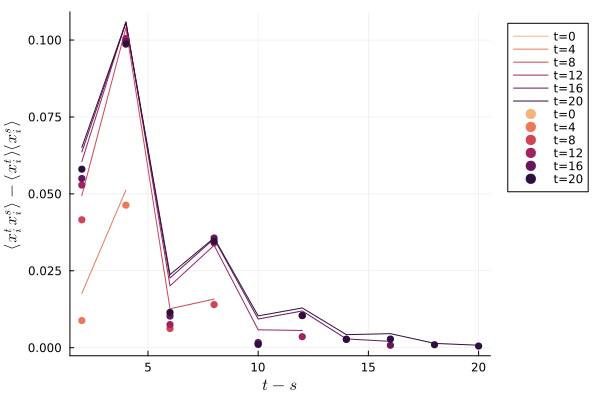

In [29]:
skip_even = true
pl = plot_autocovs(abs.(mean(c_bp)); skip_even)
plot_autocovs!(pl, abs.(mean(c_mc)); st=:scatter, skip_even)

In [ ]:
# jldsave("plot_data/glauber_asymm.jld2"; N, k, T, β, m⁰, m_bp, m_mc, c_bp, c_mc);